# Hourly Energy Consumption

In [181]:
import pandas as pd 
import datetime
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.iolib.table import SimpleTable

data from https://www.kaggle.com/robikscube/hourly-energy-consumption

Рассмотрим статистику по крупнейшему в США владельцу предприятий электроэнергеники AEP (American Electric Power)

In [182]:
energy_consumption = pd.read_csv('data/AEP_hourly.csv')

In [183]:
energy_consumption['Datetime'] = pd.to_datetime(energy_consumption.Datetime)
energy_consumption.index  = energy_consumption.Datetime

In [184]:
energy_consumption.head()

,Datetime,AEP_MW
Datetime,,
2004-12-31 01:00:00,2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,2004-12-31 05:00:00,12670.0


In [180]:
energy_consumption.shape

(121273, 2)

Данные представляют из себя данные о потреблении элетроэнергии с шагом каждый час, начиная с декабря 2004. Источник - датасет kaggle (как показала практика, он практически идентичен данным с eia.gov, но совершенно не нуждается в предварительной обработке, так что зачем делать лишнюю работу)

Примерный план исследования таков:
1. Оценить чисто визуально датасет в целом (за все года), в надежде найти закономерности по сезонам
2. Выкинуть все года кроме последнего и оценить более локальные закономерности (гипотеза - по выходным потребление электроэнергии меньше, потому что основные потребители - заводы цветной металлургии - на выходных стоят. А, может, и нет. Посмотрим)
3. Взять ещё меньший кусок датасета (за последний месяц) и оценить суточный цикл (вероятно, ночью потребление электроэнергии меньше)
4. Сформулировать и проверить статистические гипотезы
5. Построить предсказание временного ряда
6. Проанализировать полученные результаты

# Визуальный анализ

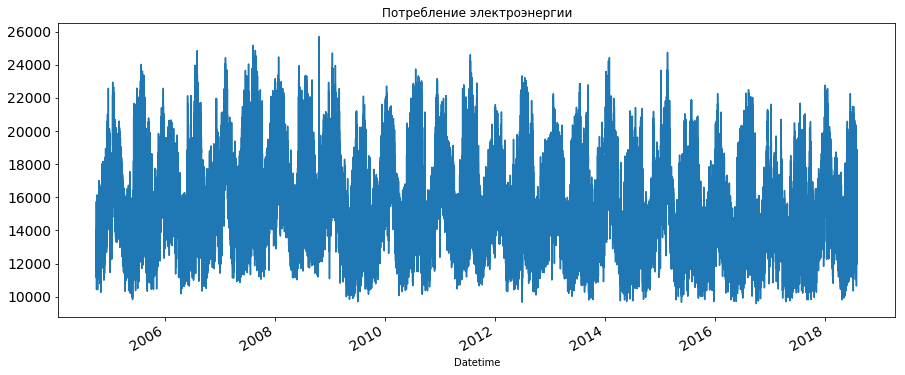

In [6]:
# визуальный анализ
energy_consumption.AEP_MW.plot( figsize=(15,6),title= 'Потребление электроэнергии', fontsize=14)

Хм.. явно есть пики каждые ~200 дней (5000 часов)

Посмотрим поближе: рассмотрим данные за последние два года (18000 часов)

In [7]:
df_year = energy_consumption.iloc[-18000:]

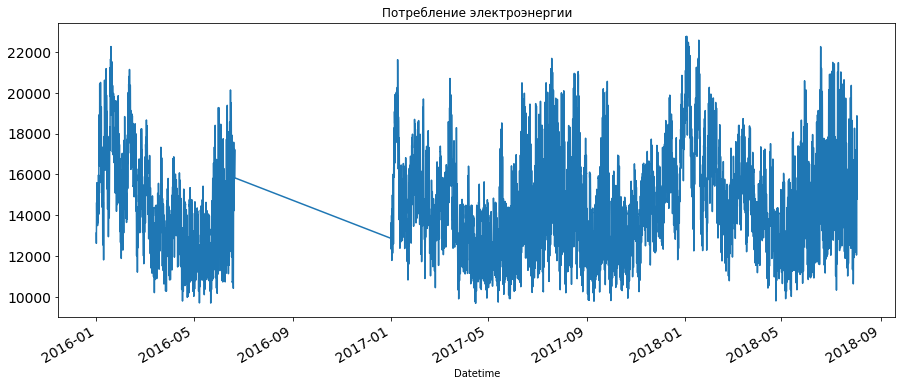

In [8]:
df_year.AEP_MW.plot( figsize=(15,6),title= 'Потребление электроэнергии', fontsize=14)

In [9]:
# в душе не шарю, откуда там взялась эта полоска
# раньше её не было
# честно
# но вы же не будетет меня минусить за слегка похудевшую гусеницу?

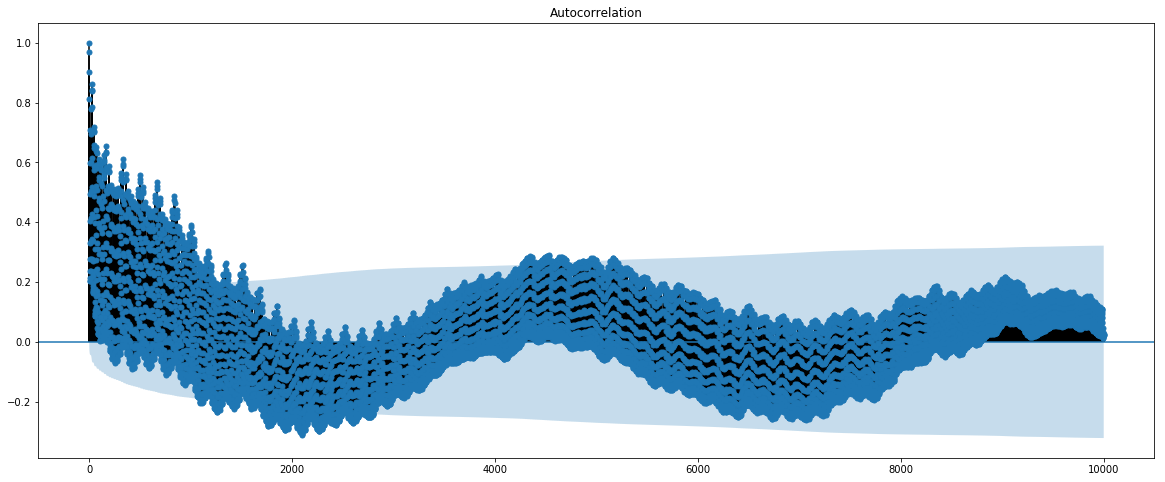

In [10]:
import statsmodels.api as sm
fig, ax = plt.subplots(figsize=(20,8))
sm.graphics.tsa.plot_acf(df_year.AEP_MW, lags=10000, ax = ax)
plt.show()

Тысяча чертей, там точно что-то есть!
Очевидно, что колесо Сансары даёт оборот каждые 5000 часов, посмотрим на последний элемент датасета (на него как раз приходится последний пик) и попробуем разобраться, в чём же причина этой периодчности

In [11]:
df_year.tail()

,Datetime,AEP_MW
Datetime,,
2018-01-01 20:00:00,2018-01-01 20:00:00,21089.0
2018-01-01 21:00:00,2018-01-01 21:00:00,20999.0
2018-01-01 22:00:00,2018-01-01 22:00:00,20820.0
2018-01-01 23:00:00,2018-01-01 23:00:00,20415.0
2018-01-02 00:00:00,2018-01-02 00:00:00,19993.0


Значит, последний пик - январь, пик до этого - примерно июнь, второй пик с конца - снова январь. С одной стороны, понять повышение потребления электроэнергии в середине зимы можно - скорее всего, это отопление. НО вот что происходит летом? Рискну предположить, что в стране загнивающего капитализма летом каждый первый использует кондиционер, что так же сказывается на потреблении электроэнергии

Перейдём рассмотрим кусочек поменьше - последний месяц (720 часов)

In [12]:
df_month = energy_consumption.iloc[-720:]

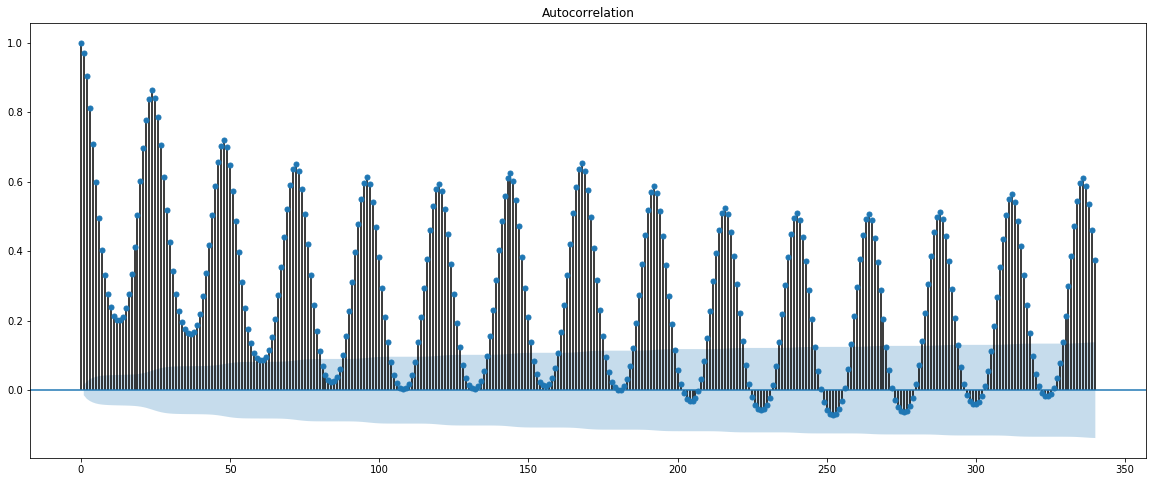

In [13]:
fig, ax = plt.subplots(figsize=(20,8))
sm.graphics.tsa.plot_acf(df_year.AEP_MW, lags=340, ax = ax) # 340 часов - ~две недели
plt.show()

Что и требовалось доказать - по коррелограмме видно, что
- каждые 24 часа происходит пик - общее потребление электроэнергии увеличивается днём и падает ночью
- если приглядеться, так же заметно, что понедельник коррелирует с понедельником больше, чем понедельник с воскресеньем => имеет место уменьшение потребления электроэнергии навыходных, хоть и не очень явно выраженное

/Library/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


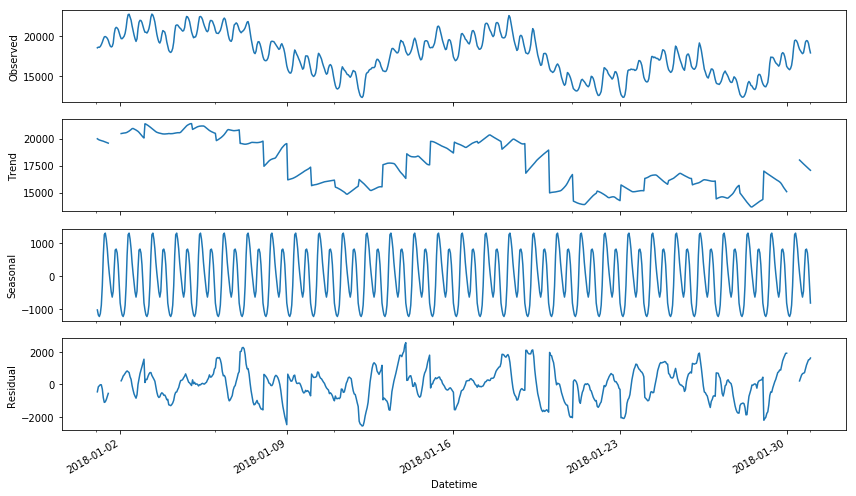

In [14]:
df_month['Datetime'] = pd.to_datetime(df_month.Datetime)
df_month.index  = df_month.Datetime

rcParams['figure.figsize'] = 12, 7
sm.tsa.seasonal_decompose(df_month.AEP_MW, freq = 24).plot()
plt.show()

С трендом творится всякая дичь, зато теперь очевидно, что потребление электроэнергии каждые сутки (24 часа) примерно одинаково

# Статистические гипотезы

На первый взгляд ряд кажется стационарным, проверим это с помощью обощённого теста Дики-Фуллера

In [16]:
test = sm.tsa.adfuller(energy_consumption.AEP_MW)
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -16.44681210468685
p-value:  2.39901132400153e-29
Critical values:  {'1%': -3.430403955318047, '5%': -2.8615638474512295, '10%': -2.566782693155802}
единичных корней нет, ряд стационарен


Мы угадали!

Сам по себе ряд на нормальное распределение не очень похож, но вдруг им является полугодовой цикл? Что же, пора достать из широких штанин тест Харки-Бера

In [17]:
df = energy_consumption.resample('W', how='mean').iloc[-120:-90]

/Library/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  """Entry point for launching an IPython kernel.


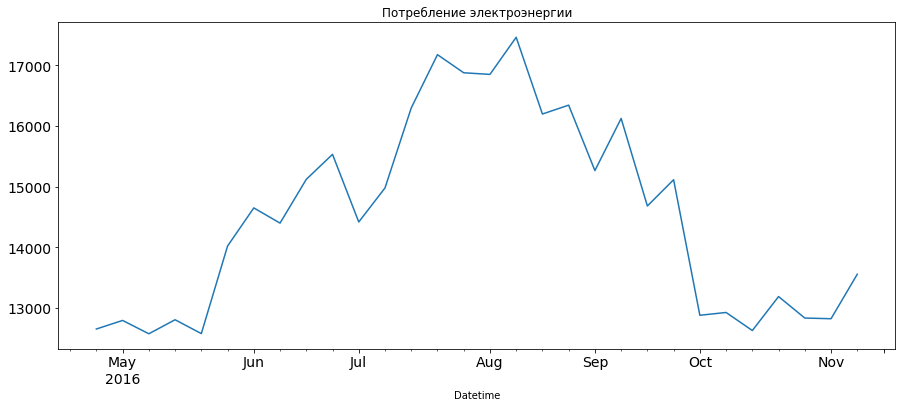

In [18]:
df.AEP_MW.plot( figsize=(15,6),title= 'Потребление электроэнергии', fontsize=14)

In [19]:
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(df.AEP_MW)
a = np.vstack([jb_test])
itog = SimpleTable(a, row)
print (itog)

        JB             p-value              skew             kurtosis    
-------------------------------------------------------------------------
2.408564561945475 0.2999071713708469 0.2641160330948274 1.716324599516923
-------------------------------------------------------------------------


Но, кажется, всё-таки нет. Впрочем, не больно-то и хотелось

# Предсказание временного ряда

In [185]:
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt

In [186]:
energy_consumption = energy_consumption.resample('W', how='mean')
energy_consumption.head()
energy_consumption.shape

/Library/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  """Entry point for launching an IPython kernel.


(723, 1)

Предскажем полугодовую динамику потребления электроэнергии, обучив модель на предыдущих 2.5 годах

Так как мы предсказываем динамику в глобальном плане, от части данных можно со спокойной душой избавиться, как это было сделано выше

In [187]:
# временной ряд
train = energy_consumption.iloc[-168:-48]
test = energy_consumption.iloc[-48:]

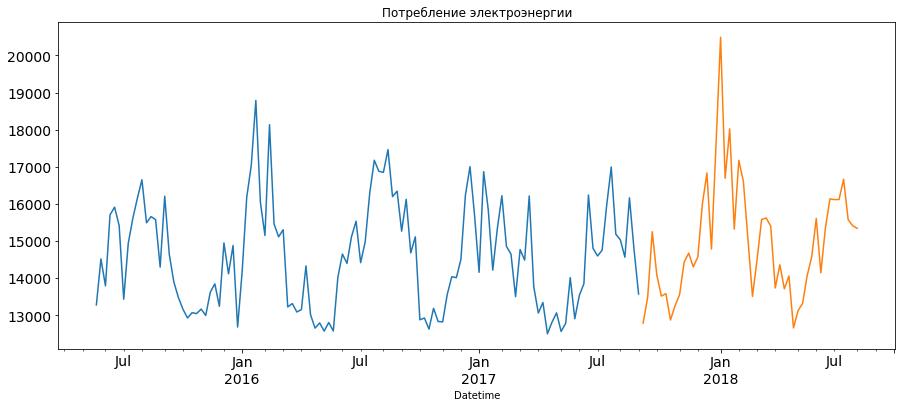

In [188]:
train.AEP_MW.plot( figsize=(15,6),title= 'Потребление электроэнергии', fontsize=14)
test.AEP_MW.plot( figsize=(15,6),title= 'Потребление электроэнергии', fontsize=14)

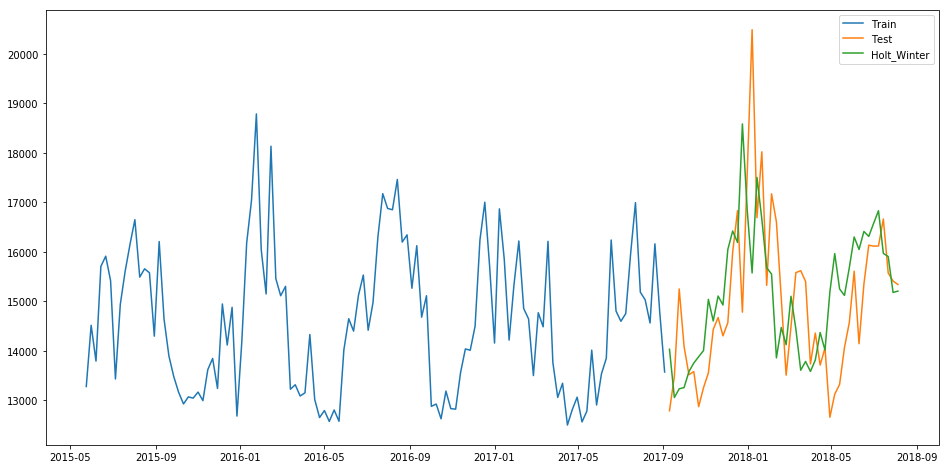

In [189]:
fit1 = ExponentialSmoothing(np.asarray(train.AEP_MW) ,seasonal_periods=50 ,trend='add', seasonal='add',).fit()
y_hat = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train.AEP_MW, label='Train')
plt.plot(test.AEP_MW, label='Test')

buf = test.copy()

result = pd.DataFrame(buf)
result.AEP_MW = y_hat
plt.plot(result, label='Holt_Winter')


plt.legend(loc='best')
plt.show()

In [190]:
rms = sqrt(mean_squared_error(test.AEP_MW, y_hat))
print(rms)

1463.6702153286903


# Заключение

Итак, мы узнали, что
- потребление электроэнергии, в общем-то, стационарно и вот уже десять лет как никуда не меняется
- заметили, что ночью (как ни странно!) электричества потребляют гораздо меньше, чем днём
- так же заметили, что годовые пики потребления электроэнергии приходятся на зиму (что кажется логичным) и, (а вот этого я действительно не ожидал) на лето
- предсказали расход электроэнергии на ближайшие полгода, боже, какие мы крутые энергетики